In [1]:
import pandas, os, re, sys, importlib, random, functools
import numpy as np

import write_excel
import language
import annotater
import fbfTargetSet
import targetSet
import complexTargetSet

import orthoListHelper
import pum2Helper
import fbfTargetHelper

In [2]:
##################
# Orthology data.

if not os.path.exists('output/'):
    os.system('mkdir output/')

# This is a map of worm loci <-> human ENSG ids of orthologs.
orthos = orthoListHelper.orthoListHelper().read_ortholist_file('lib/OrthoList_20130531.csv', max_orthologs=2)
#print('gld-1 translation:', ortho_cmap.translate(input_id='T23G11.3', verbose=True))

Reading ortholist file, line:  0
Reading ortholist file, line:  1000
Reading ortholist file, line:  2000
Reading ortholist file, line:  3000
Reading ortholist file, line:  4000
Reading ortholist file, line:  5000
Reading ortholist file, line:  6000
Reading ortholist file, line:  7000
Have 794 Ensmbl language IDs in two gene sets...
language.complexTranslation info: {'Name': 'Unnamed complexTranslation object', 'gene sets a': 5188, 'gene sets b': 3911}


In [3]:
def simplify_locus_id(locus_id):
    
    txpt = locus_id.split('.')
    if len(txpt) > 1:
        locus_id = '.'.join(txpt[:2])
        
    return re.sub('[a-z]$', '', locus_id)

def top_500_genes(df):
    # Dataframe already sorted.
    
    genes_obs = set()
    gene_rank = []
    for gene in df.transcript_id:
        if len(gene):
            genes_obs.add(simplify_locus_id(gene))
        gene_rank.append(len(genes_obs))

    df['Gene rank'] = gene_rank
    top = df[df['Gene rank']<501].copy()
    
    print('Ranked {0} genes.'.format(len(genes_obs)))
    print('Check: {0} locus ids/{1} gene names simplified to {2}.'.format(
        len(set(df['transcript_id'].tolist())), len(set(df['Gene name'].tolist())),len(genes_obs)))
    print('top 500 -> indexes {0} (may be >1 per gene), genes {1}'.format(
        len(top.index), len(set(top['Gene name']))))
    return top

def load_excel(fname, sheetname, worm_translator):
    df = pandas.read_excel(fname, index_col=False, sheetname=sheetname)

    if ('transcript_id' not in df.columns) and ('Transcript' in df.columns):
        df['transcript_id'] = df['Transcript']

    elif ('transcript_id' not in df.columns) and ('Gene name' in df.columns):
        print('Using Gene name...')
        df['transcript_id'] = [worm_translator.translate(
            input_id=name, return_str=True, multiple_homologs_in_native_language_possible=False) \
            for name in df['Gene name']]
        
    return df


In [7]:


importlib.reload(language)
importlib.reload(annotater)
importlib.reload(fbfTargetSet)
importlib.reload(targetSet)
importlib.reload(complexTargetSet)
importlib.reload(write_excel)
importlib.reload(orthoListHelper)
importlib.reload(pum2Helper)
importlib.reload(fbfTargetHelper)



def find_and_write_overlap_with_pum2(
        pum2_ensembl_ts, orthos, sheetname, writer, fbf_df=None):

    print('\nFinding overlap with PUM2 and {0}.'.format(sheetname))
    
    fbf = fbfTargetSet.fbfTargetSet(input_df=fbf_df)
    
    input_fbf_targets = len(fbf.fbf_cts.cgenes)
    
    fbf.fbf_cts.remove_nontranslatable_cgenes(orthos[2])  # orthos[2] is a worm loci<>ENSG translator.
    
    fbf.fbf_cts.combine_targets_based_on_homology(orthos[2])
    table = fbf.fbf_cts.overlap_with_complexTargetSet(pum2_ensembl_ts, orthos[2], verbose=True)
    
    print('\nIdentified overlap with PUM2. Annotating the FBF targets and outputing to excel.')
    
    fbf_targs = fbf.annotate_fbf_targs_df(pum2_ensembl_ts, orthos)
    
    if writer is not None:
        write_excel.write_tab3(fbf_targs, sheet_name=sheetname, writer=writer)

    #fbf_targs.to_csv('output/fbf_targs_with_overlap.txt', index=False, sep='\t')
    
    print('\nWrote to excel. Finished comparing PUM2 and {0}.'.format(sheetname))
    
    table['Name'] = sheetname
    table['FBF targets input'] = input_fbf_targets
    
    including_homologs = fbf.fbf_cts.to_dataframe()
    table['FBF targets including homologs'] = len(including_homologs.index)
    including_homologs_shared = including_homologs[including_homologs['shared']==1]
    table['FBF targets shared including homologs'] = len(including_homologs_shared.index)
    
    print(table)
    return table


##################
# PUM2 targets.
# Get a complexTargetSet object of PUM2 targets translated to ENSG using the ortholist data.
# Only targets with worm homologs can be translated.
# This complexTargetSet object of PUM2 targets removes any ENSG without worm loci.
pum2_ensembl_ts = pum2Helper.pum2Helper().pum2_targets_as_ensembl(orthos)


##################
# Worm Gene name <-> Locus ID translator.
worm_translator = fbfTargetHelper.fbfTargetHelper().get_gene_name_locus_id_mapper(
    '/opt/lib/worm_txpt_id_gene_name_map.txt')
#print(worm_translator.translate(
#    input_id='gld-1', return_str=True, multiple_homologs_in_native_language_possible=False))


##################
# FBF targets.

top_dir = '/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/'
writer = pandas.ExcelWriter('output/File S7 conservation.xls')

overlap_table = []

all_fbf_targets = set()
file_sheet_name_tups = [
    (top_dir + '/tables/Table S1 Peaks.xls', 'OO FBF (25°C)'),
    (top_dir + '/tables/Table S1 Peaks.xls', 'SP FBF (25°C)'),
    (top_dir + '/tables/Table S1 Peaks.xls', 'OO FBF-1 (20°C)'),  
    (top_dir + '/tables/Table S1 Peaks.xls', 'OO FBF-2 (20°C)'),
    (top_dir + '/tables/Table S6 Blocks.xls', 'Block I'),
    (top_dir + '/tables/Table S6 Blocks.xls', 'Block II'),
    (top_dir + '/tables/Table S6 Blocks.xls', 'Block III'),
    ]

for fname, sheetname in file_sheet_name_tups:
    print("\n---\nLoading {0} - {1}".format(fname, sheetname))

    # Load file.
    if os.path.basename(fname).split('.')[-1] in ['xls', 'xlsx']:
        df = pandas.read_excel(fname, index_col=False, sheetname=sheetname)

        if ('transcript_id' not in df.columns) and ('Transcript' in df.columns):
            df['transcript_id'] = df['Transcript']

        elif ('transcript_id' not in df.columns) and ('Gene name' in df.columns):
            print('Using Gene name...')
            df['transcript_id'] = [worm_translator.translate(
                input_id=name, return_str=True, multiple_homologs_in_native_language_possible=False) \
                for name in df['Gene name']]

    print("Loaded file, finding overlaps.")
    all_fbf_targets |= set(df.transcript_id)

    overlap_table.append(find_and_write_overlap_with_pum2(
        pum2_ensembl_ts, orthos, sheetname, writer, fbf_df=df.copy()))

    # Top 500.
    if re.search('S1', fname):
        df.sort_index(by='Rank', inplace=True)


        
        overlap_table.append(find_and_write_overlap_with_pum2(
            pum2_ensembl_ts, orthos, sheetname + ' top 500', writer, fbf_df=top_500_genes(df)))

##################
# Special cases, FBF targets.    
# overlap_table.append(find_and_write_overlap_with_pum2(
#         pum2_ensembl_ts, orthos, 'All datasets', writer, 
#    fbf_df=pandas.DataFrame({'transcript_id': list(all_fbf_targets)})))

oo = load_excel(top_dir + '/tables/Table S1 Peaks.xls', 'OO FBF (25°C)', worm_translator)
sp = load_excel(top_dir + '/tables/Table S1 Peaks.xls', 'SP FBF (25°C)', worm_translator)
common_genes = set(oo['transcript_id'].tolist()) & set(sp['transcript_id'].tolist())

common = pandas.concat([oo, sp])
common = common[[x in common_genes for x in common.transcript_id]].copy()

overlap_table.append(find_and_write_overlap_with_pum2(
         pum2_ensembl_ts, orthos, 'Common', writer, 
    fbf_df=common))

common.sort_index(by='Peak height (reads/million)', ascending=False)

overlap_table.append(find_and_write_overlap_with_pum2(
    pum2_ensembl_ts, orthos, 'Common top 500', writer, 
    fbf_df=top_500_genes(common)))

writer.save()

overlaps = pandas.DataFrame(overlap_table)

print('Done.')

...Created a complexTargetSet (PUM2) in language Ensmbl:
{'Number of gene sets': 2580, 'Native language': 'Ensmbl', 'Name': 'PUM2'}
Total number of loci in ortholist: 7647. With translation to ESNGxx: 7639.
complexTranslation.qc(): All IDs are in one gene set.
Removing non-translatable genes: input 2580
...943 were translatable.

---
Loading /Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl//tables/Table S1 Peaks.xls - OO FBF (25°C)
Loaded file, finding overlaps.

Finding overlap with PUM2 and OO FBF (25°C).
...Created a complexTargetSet (FBF) in language Loci:
{'Number of gene sets': 1742, 'Native language': 'Loci', 'Name': 'FBF'}
Removing non-translatable genes: input 1742
...908 were translatable.
Combining targets in language Loci based on overlapping translations Locus ID->Ensmbl
Input is 908  IDs (unflattened), 908 (flattened)
After collapse: 873  IDs (unflattened), 873 (flattened)
This complexTargetSet has 873 IDs of the form: frozenset({'Y37D8A.21'})
It's

/Users/dfporter/Desktop/macbook_air_Desktop/shared/sp_oo/FBF_gendered_gl/orthos/write_excel.py:23: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  fbf_targs.sort_index(by=['Gene name'], inplace=True)
/Users/dfporter/pma/venv/lib/python3.6/site-packages/ipykernel_launcher.py:111: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)



Wrote to excel. Finished comparing PUM2 and OO FBF (25°C).
defaultdict(<class 'int'>, {'b_target_only': 863, 'not_a_or_b_target': 3452, 'a_target_only': 616, 'shared_targets': 257, 'Name': 'OO FBF (25°C)', 'FBF targets input': 1742, 'FBF targets including homologs': 908, 'FBF targets shared including homologs': 270})
Ranked 1742 genes.
Check: 1758 locus ids/1742 gene names simplified to 1742.
top 500 -> indexes 532 (may be >1 per gene), genes 500

Finding overlap with PUM2 and OO FBF (25°C) top 500.
...Created a complexTargetSet (FBF) in language Loci:
{'Number of gene sets': 500, 'Native language': 'Loci', 'Name': 'FBF'}
Removing non-translatable genes: input 500
...225 were translatable.
Combining targets in language Loci based on overlapping translations Locus ID->Ensmbl
Input is 225  IDs (unflattened), 225 (flattened)
After collapse: 212  IDs (unflattened), 212 (flattened)
This complexTargetSet has 212 IDs of the form: frozenset({'T04C4.1'})
It's info is:
complexTargetSet info:  {

/Users/dfporter/pma/venv/lib/python3.6/site-packages/ipykernel_launcher.py:135: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


...229 were translatable.
Combining targets in language Loci based on overlapping translations Locus ID->Ensmbl
Input is 229  IDs (unflattened), 229 (flattened)
After collapse: 215  IDs (unflattened), 215 (flattened)
This complexTargetSet has 215 IDs of the form: frozenset({'ZK1307.6'})
It's info is:
complexTargetSet info:  {'Number of gene sets': 215, 'Native language': 'Loci', 'Name': 'FBF'}

a_language_ids_with_translation (superset of a_targets): 5188, ex: "[frozenset({'F47E1.4'})]"
b_language_ids_with_translation (superset of b_targets): 3911, ex: "[frozenset({'ENSG00000198130'})]"
a_targets_with_translations to lang b (unflattened): 215, ex: "[frozenset({'ZK632.7'})]"
b_targets_with_translations to lang a (unflattened): 943, ex: "[frozenset({'ENSG00000162104'})]"
a_targets_with_translations to lang b (flattened): 215, ex: "['F59A6.5']"
all_a_target_ids in lang b after many<->many translation (flattened): 295, ex: "['ENSG00000214575']"
all_b_target_ids in lang b (flattened): 943, 

Index(['OO FBF-1 (20°C)', 'OO FBF-1 (20°C) top 500', 'OO FBF-2 (20°C)',
       'OO FBF-2 (20°C) top 500', 'OO FBF (25°C)', 'OO FBF (25°C) top 500',
       'SP FBF (25°C)', 'SP FBF (25°C) top 500', 'Common', 'Common top 500',
       'Block I', 'Block II', 'Block III', 'All mRNA'],
      dtype='object', name='Name')
                         FBF targets including homologs  FBF targets input  \
Name                                                                         
OO FBF-1 (20°C)                                     982               1882   
OO FBF-1 (20°C) top 500                             223                500   
OO FBF-2 (20°C)                                    1161               2194   
OO FBF-2 (20°C) top 500                             211                500   
OO FBF (25°C)                                       908               1742   
OO FBF (25°C) top 500                               225                500   
SP FBF (25°C)                                      1010     

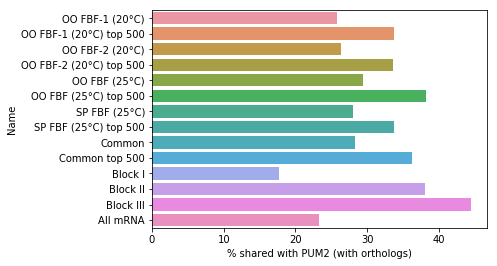

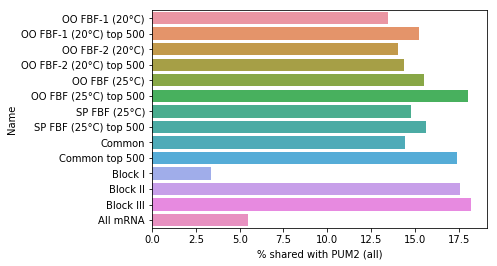

In [24]:
#overlap_table.append({})

def random_transcript_ids(orthos):
    
    gtf = pandas.read_csv('/opt/lib/gtf_with_names_column.txt', sep='\t')

    gtf = gtf[gtf['biotype']=='protein_coding']
    ok_transcripts = set([simplify_locus_id(x) for x in gtf['transcript_id'].tolist()])
    
    locus_id_to_row, human_ensembl_to_locus_id, complexTransl = orthos
    #sample = random.sample(list(locus_id_to_row.keys()), 2000)
    
#    sample = random.sample(ok_transcripts, 2000)
    sample = [{'transcript_id': x} for x in ok_transcripts]# if x in ok_transcripts]
    df = pandas.DataFrame(sample)
    return df
    #fbf = fbfTargetSet.fbfTargetSet(input_df=df)
    #fbf.fbf_cts.remove_nontranslatable_cgenes(orthos[2])
    #fbf.fbf_cts.combine_targets_based_on_homology(orthos[2])
    #table = fbf.fbf_cts.overlap_with_complexTargetSet(pum2_ensembl_ts, orthos[2], verbose=True)
    #table['Name'] = 'Random'
    #print(table)

    #fbf.fbf_cts.stats()
#    print(sample)
skippy = '''
overlap_table = [row for row in overlap_table if not re.search('Random', row['Name'])]
overlap_table = [row for row in overlap_table if not re.search('Genome', row['Name'])]
overlap_table = [row for row in overlap_table if not re.search('All mRNA', row['Name'])]

overlap_table.append(find_and_write_overlap_with_pum2(
    pum2_ensembl_ts, orthos, 'All mRNA', None, 
    fbf_df=random_transcript_ids(orthos)))
'''
overlaps = pandas.DataFrame(overlap_table)    

import seaborn as sns
import matplotlib.pyplot as plt

def refresh():
    plt.clf()
    plt.close()

overlaps['FBF targets'] = [a+ab for a, ab in zip(overlaps.a_target_only, overlaps.shared_targets)]
overlaps['% shared with PUM2 (all)'] = [100*ab/t for t, ab in zip(
    overlaps['FBF targets input'], overlaps['FBF targets shared including homologs'])]

overlaps['% shared with PUM2 (with orthologs)'] = [
    100*ab/t for ab, t in zip(overlaps.shared_targets, overlaps['FBF targets'])]

overlaps.index = overlaps.Name

order = ['OO FBF-1 (20°C)', 'OO FBF-1 (20°C) top 500',
 'OO FBF-2 (20°C)', 'OO FBF-2 (20°C) top 500',
 'OO FBF (25°C)', 'OO FBF (25°C) top 500', 
 'SP FBF (25°C)', 'SP FBF (25°C) top 500', 
 'Common', 'Common top 500', 
        'Block I', 'Block II',
       'Block III', 'All mRNA']
overlaps = overlaps.reindex(order)
print(overlaps.index)
print(overlaps)

refresh()
fig = plt.figure()
sns.barplot(x='% shared with PUM2 (with orthologs)', y='Name', data=overlaps)
fig.savefig('../figs/shared_with_PUM2_with_orthologs.pdf')
plt.show()
refresh()

fig = plt.figure()
sns.barplot(x='% shared with PUM2 (all)', y='Name', data=overlaps)
fig.savefig('../figs/shared_with_PUM2.pdf')
plt.show()
refresh()

In [233]:
gtf = pandas.read_csv('/opt/lib/gtf_with_names_column.txt', sep='\t')
print(gtf.head())
print(gtf.biotype.value_counts())

   0        1           2    3    4  5  6  7  \
0  V  ensembl        gene  180  329  .  +  .   
1  V  ensembl  transcript  180  329  .  +  .   
2  V  ensembl        exon  180  329  .  +  .   
3  V  ensembl        gene  180  329  .  -  .   
4  V  ensembl  transcript  180  329  .  -  .   

                                                   8 gene_name transcript_id  \
0  gene_id "WBGene00197333"; gene_version "1"; ge...  cTel3X.2             .   
1  gene_id "WBGene00197333"; gene_version "1"; tr...  cTel3X.2      cTel3X.2   
2  gene_id "WBGene00197333"; gene_version "1"; tr...  cTel3X.2      cTel3X.2   
3  gene_id "WBGene00198386"; gene_version "1"; ge...  cTel3X.3             .   
4  gene_id "WBGene00198386"; gene_version "1"; tr...  cTel3X.3      cTel3X.3   

  transcript_name exon_number         gene_id biotype  
0               .           .  WBGene00197333   ncRNA  
1        cTel3X.2           .  WBGene00197333   ncRNA  
2        cTel3X.2           1  WBGene00197333   ncRNA  
3     

In [ ]:
# Make the figure.
file_sheet_name_tups = [
    (top_dir + '/tables/Table S1 Peaks.xls', 'OO FBF (25°C)'),
    (top_dir + '/tables/Table S1 Peaks.xls', 'SP FBF (25°C)'),
    (top_dir + '/tables/Table S1 Peaks.xls', 'OO FBF-1 (20°C)'),  
    (top_dir + '/tables/Table S1 Peaks.xls', 'OO FBF-2 (20°C)'),
    (top_dir + '/tables/Table S6 Blocks.xls', 'Block I'),
    (top_dir + '/tables/Table S6 Blocks.xls', 'Block II'),
    (top_dir + '/tables/Table S6 Blocks.xls', 'Block III'),
    ]
overlaps, peaks = ({}, {})
for fname, sheetname in file_sheet_name_tups:
    overlaps[sheetname] = pandas.read_excel(fname, index_col=False, sheetname=sheetname)
    if re.search('Table S1', fname):
        peaks[sheetname] = pandas.read_excel(
            top_dir + '/tables/Table S1 Peaks.xls', index_col=False, sheetname=sheetname)



In [162]:
importlib.reload(fbfTargetSet)
df = pandas.DataFrame([
    {'Locus ID': list(x)[0], 'a_target': 1, 'translations': orthos[2].translate(x)} for x in list(fbf.fbf_cts.cgenes)])

_fbf = fbfTargetSet.fbfTargetSet(input_df=df)

_fbf_targs = _fbf.annotate_fbf_targs_df(pum2_ensembl_ts, orthos, use_this_df=df)

ann = annotater.annotater(
    pandas.read_csv('lib/OrthoList_20130531.csv', sep=','),
    name='Ortholist')

ann.create_mapping('Locus ID')

_fbf_targs = ann.annotate_a_dataframe(_fbf_targs, key='Locus ID')

print(df)

AttributeError: 'set' object has no attribute 'split'

In [161]:
a = set([])
a.add('asdfas')
a = frozenset(a)
list(a)

['asdfas']